In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, 

####Read in sample metadata and OTU table

In [22]:
%%R 
physeq = import_biom("data/otu_table_250_wtax.biom", "data/otusn.tree")
print(physeq)
sample.data = import_qiime_sample_data("data/Chazy_BulkSIP_mapping.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
print(physeq)
physeq = prune_samples((physeq.md$Substrate !="H2O"),physeq) 
physeq
physeq.md = sample_data(physeq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3632 taxa and 112 samples ]
tax_table()   Taxonomy Table:    [ 3632 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3632 tips and 3631 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3632 taxa and 112 samples ]
sample_data() Sample Data:       [ 112 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 3632 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3632 tips and 3631 internal nodes ]


In [4]:
%%R
mdf = tbl_df(psmelt(physeq))

In [108]:
%%R
NT1 = filter(mdf, Till == "NTH", Day == 1, Abundance > 0)
NT3 = filter(mdf, Till == "NTH", Day == 3, Abundance > 0)
NT7 = filter(mdf, Till == "NTH", Day == 7, Abundance > 0)
NT14 = filter(mdf, Till == "NTH", Day == 14, Abundance > 0)
NT30 = filter(mdf, Till == "NTH", Day == 30, Abundance > 0)
PT1 = filter(mdf, Till == "PTH", Day == 1, Abundance > 0)
PT3 = filter(mdf, Till == "PTH", Day == 3, Abundance > 0)
PT7 = filter(mdf, Till == "PTH", Day == 7, Abundance > 0)
PT14 = filter(mdf, Till == "PTH", Day == 14, Abundance > 0)
PT30 = filter(mdf, Till == "PTH", Day == 30, Abundance > 0)

one= filter(mdf, Day == 1, Abundance > 0)
three = filter(mdf, Day == 3, Abundance > 0)
seven = filter(mdf, Day == 7, Abundance > 0)
fourteen = filter(mdf, Day == 14, Abundance > 0)
thirty = filter(mdf, Day == 30, Abundance > 0)
#length(unique(NT30$OTU))
#length(unique(PT30$OTU))
#length(intersect(NT30$OTU, PT30$OTU))
length(unique(thirty$OTU))


[1] 2945


In [23]:
%%R
get_l2fc = function(physeq.obj, Day, Substrate) {
    physeq.md = sample_data(physeq.obj)
    p = prune_samples((physeq.md$Day == Day) & (physeq.md$Substrate == Substrate), physeq.obj)
    dds = phyloseq_to_deseq2(p, ~ Till)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    r = results(dds, independentFiltering = TRUE, lfcThreshold = 0, cooksCutoff = FALSE, pAdjustMethod = "BH")
    r$OTU = rownames(r)
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)
    d
}

In [24]:
%%R
unique(physeq.md$Substrate)

[1] 12C 13X 13C
Levels: 12C 13C 13X


In [25]:
%%R
m = expand.grid(Day = c(1,3,7,14,30), Substrate = c("12C", "13C", "13X"))
m = m[-c(6, 15), ]
m

   Day Substrate
1    1       12C
2    3       12C
3    7       12C
4   14       12C
5   30       12C
7    3       13C
8    7       13C
9   14       13C
10  30       13C
11   1       13X
12   3       13X
13   7       13X
14  14       13X


In [26]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(m, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq))
df.l2fc

Source: local data frame [47,216 x 14]

   Day Substrate      OTU log2FoldChange     lfcSE      padj      Rank1
1    1       12C OTU.2451             NA        NA        NA Unassigned
2    1       12C OTU.2213             NA        NA        NA   Bacteria
3    1       12C OTU.2244             NA        NA        NA   Bacteria
4    1       12C OTU.2893             NA        NA        NA   Bacteria
5    1       12C OTU.2716             NA        NA        NA   Bacteria
6    1       12C  OTU.189     0.19181912 1.0264703 0.9516379   Bacteria
7    1       12C OTU.1062    -1.03644502 2.1293778        NA   Bacteria
8    1       12C OTU.1297     0.70622055 0.7750130 0.6858122   Bacteria
9    1       12C  OTU.226    -0.06425983 0.7360697 0.9802853   Bacteria
10   1       12C  OTU.168     1.01478489 1.0904407 0.6786825   Bacteria
.. ...       ...      ...            ...       ...       ...        ...
Variables not shown: Rank2 (fctr), Rank3 (fctr), Rank4 (fctr), Rank5 (fctr),
  Rank6 (fctr), Ran

In [ ]:
%%R
summarise(df.l2fc,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

In [ ]:
%%R
summarise(df.l2fc,
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

In [27]:
%%R
df.l2fc$Till[df.l2fc$log2FoldChange > 0] = "NT"
df.l2fc$Till[df.l2fc$log2FoldChange <0] = "PT"

In [28]:
%%R
write.table(df.l2fc, "data/l2fc_table_bulk_NTPT", row.names = FALSE, sep = ",")

####Function arguments

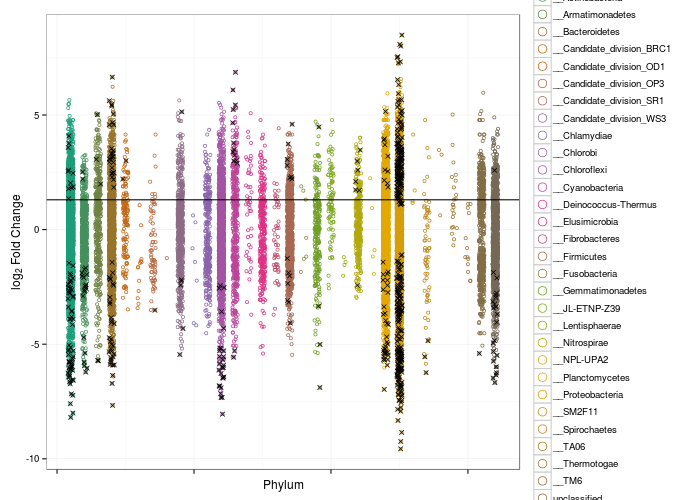

In [29]:
%%R -w 700 -h 500
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))
#p = p + facet_wrap(~Substrate)#, nrow=1, ncol=4)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj <= FDR), color = "black", shape = 4, size = 2)

p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p

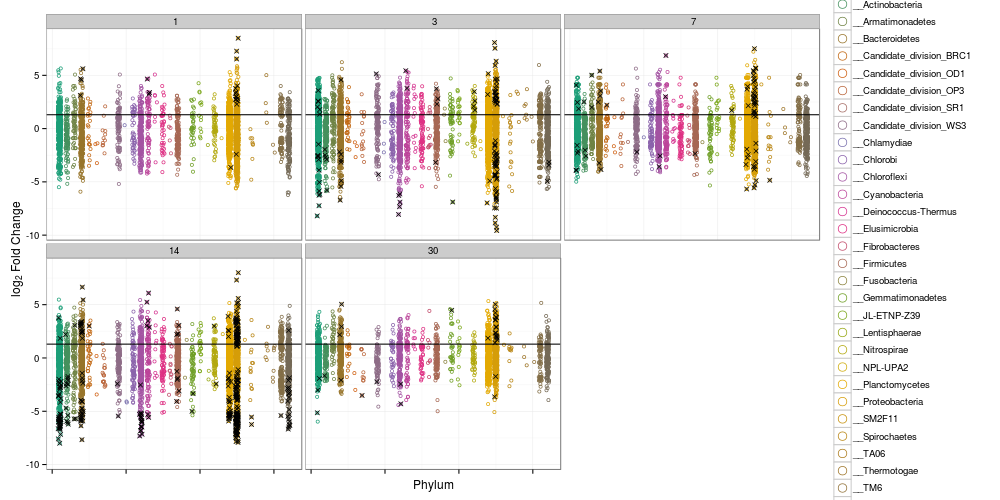

In [30]:
%%R -w 1000 -h 500
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))
p = p + facet_wrap(~Day)#, nrow=1, ncol=4)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj <= FDR), color = "black", shape = 4, size = 2)

p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p

In [177]:
%%R
PTresp = filter(df.l2fc, padj <=0.10, log2FoldChange < 0)
length(unique(PTresp$OTU))

[1] 237


In [180]:
%%R
PTresp = filter(df.l2fc, padj <=0.10, log2FoldChange < 0)
length((PTresp$OTU))

[1] 391


In [178]:
%%R
NTresp = filter(df.l2fc, padj <=0.10, log2FoldChange > 0)
length(unique(NTresp$OTU))

[1] 107


In [181]:
%%R
NTresp = filter(df.l2fc, padj <=0.10, log2FoldChange > 0)
length((NTresp$OTU))

[1] 229


In [212]:
%%R
tail(df.l2fc)

Source: local data frame [6 x 15]

  Day Substrate      OTU log2FoldChange    lfcSE      padj      Rank1
1  30       H2O  OTU.574      -1.135223 1.150097 0.9005316   Bacteria
2  30       H2O OTU.2312             NA       NA        NA Unassigned
3  30       H2O OTU.2037      -2.419474 1.467441 0.8856335   Bacteria
4  30       H2O OTU.1745      -4.243798 1.903410 0.8834160   Bacteria
5  30       H2O OTU.2983             NA       NA        NA   Bacteria
6  30       H2O OTU.3450             NA       NA        NA   Bacteria
Variables not shown: Rank2 (fctr), Rank3 (fctr), Rank4 (fctr), Rank5 (fctr),
  Rank6 (fctr), Rank7 (fctr), Rank8 (fctr), Till (chr)


In [86]:
%%R
NT1 = filter(df.l2fc, Till == "NT", Substrate !="H2O", Day == 1, padj <= 0.10)
NT3 = filter(df.l2fc, Till == "NT",Substrate !="H2O", Day == 3, padj <= 0.10)
NT7 = filter(df.l2fc, Till == "NT", Substrate !="H2O",Day == 7, padj <= 0.10)
NT14 = filter(df.l2fc, Till == "NT", Substrate !="H2O",Day == 14, padj <= 0.10)
NT30 = filter(df.l2fc, Till == "NT",Substrate !="H2O", Day == 30, padj <= 0.10)
PT1 = filter(df.l2fc, Till == "PT", Substrate !="H2O",Day == 1, padj <= 0.10)
PT3 = filter(df.l2fc, Till == "PT", Substrate !="H2O",Day == 3, padj <= 0.10)
PT7 = filter(df.l2fc, Till == "PT", Substrate !="H2O",Day == 7, padj <= 0.10)
PT14 = filter(df.l2fc, Till == "PT",Substrate !="H2O", Day == 14, padj <= 0.10)
PT30 = filter(df.l2fc, Till == "PT", Substrate !="H2O",Day == 30, padj <= 0.10)
#length(unique(NT30$OTU))
length(unique(NT30$OTU))
#length(intersect(NT7$OTU, PT7$OTU))

[1] 22


In [75]:
%%R
NT1 = filter(df.l2fc, Till == "NT",Substrate !="H2O", Day == 1, padj > 0.10)
NT3 = filter(df.l2fc, Till == "NT",Substrate !="H2O", Day == 3, padj > 0.10)
NT7 = filter(df.l2fc, Till == "NT", Substrate !="H2O",Day == 7, padj > 0.10)
NT14 = filter(df.l2fc, Till == "NT",Substrate !="H2O", Day == 14, padj > 0.10)
NT30 = filter(df.l2fc, Till == "NT",Substrate !="H2O", Day == 30, padj > 0.10)
PT1 = filter(df.l2fc, Till == "PT", Substrate !="H2O",Day == 1, padj > 0.10)
PT3 = filter(df.l2fc, Till == "PT", Substrate !="H2O",Day == 3, padj > 0.10)
PT7 = filter(df.l2fc, Till == "PT", Substrate !="H2O",Day == 7, padj > 0.10)
PT14 = filter(df.l2fc, Till == "PT",Substrate !="H2O", Day == 14, padj > 0.10)
PT30 = filter(df.l2fc, Till == "PT",Substrate !="H2O", Day == 30, padj > 0.10)

NT.na.1 = filter(df.l2fc, Till == "NT",Substrate !="H2O", Day == 1, is.na(padj))
NT.na.3 = filter(df.l2fc, Till == "NT",Substrate !="H2O", Day == 3, is.na(padj))
NT.na.7 = filter(df.l2fc, Till == "NT",Substrate !="H2O", Day == 7, is.na(padj))
NT.na.14= filter(df.l2fc, Till == "NT",Substrate !="H2O", Day == 14, is.na(padj))
NT.na.30= filter(df.l2fc, Till == "NT",Substrate !="H2O", Day == 30, is.na(padj))
PT.na.1 = filter(df.l2fc, Till == "PT",Substrate !="H2O", Day == 1, is.na(padj))
PT.na.3 = filter(df.l2fc, Till == "PT",Substrate !="H2O", Day == 3, is.na(padj))
PT.na.7 = filter(df.l2fc, Till == "PT",Substrate !="H2O", Day == 7, is.na(padj))
PT.na.14= filter(df.l2fc, Till == "PT",Substrate !="H2O", Day == 14, is.na(padj))
PT.na.30= filter(df.l2fc, Till == "PT",Substrate !="H2O", Day == 30, is.na(padj))
#length(unique(NT30$OTU))
#length(unique(PT14$OTU))
#length(intersect(NT14$OTU, PT14$OTU))
length(unique(NT.na.30$OTU))
#length(unique(PT.na.30$OTU))
#length(intersect(NT.na.30$OTU, PT.na.30$OTU))


[1] 1484


In [112]:
%%R 
new_df.l2fc = df.l2fc %>% 
filter(!is.na(log2FoldChange)) %>% 
filter(!is.na(padj)) %>%
select(log2FoldChange, padj, OTU, Rank2, Rank4, Day, Substrate) 


In [113]:
%%R
head(new_df.l2fc)

Source: local data frame [6 x 7]

  log2FoldChange      padj      OTU           Rank2
1     0.19181912 0.9516379  OTU.189 __Acidobacteria
2     0.70622055 0.6858122 OTU.1297 __Acidobacteria
3    -0.06425983 0.9802853  OTU.226 __Acidobacteria
4     1.01478489 0.6786825  OTU.168 __Acidobacteria
5    -0.45319470 0.8735299 OTU.2382 __Acidobacteria
6     0.04681156 0.9802853  OTU.135 __Acidobacteria
Variables not shown: Rank4 (fctr), Day (dbl), Substrate (fctr)


In [114]:
%%R
new_df.l2fc$Resp_status[new_df.l2fc$padj > 0.10] = "non-responder"
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 & new_df.l2fc$log2FoldChange > 0] = "NT enriched"
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 &  new_df.l2fc$log2FoldChange < 0] = "PT enriched"

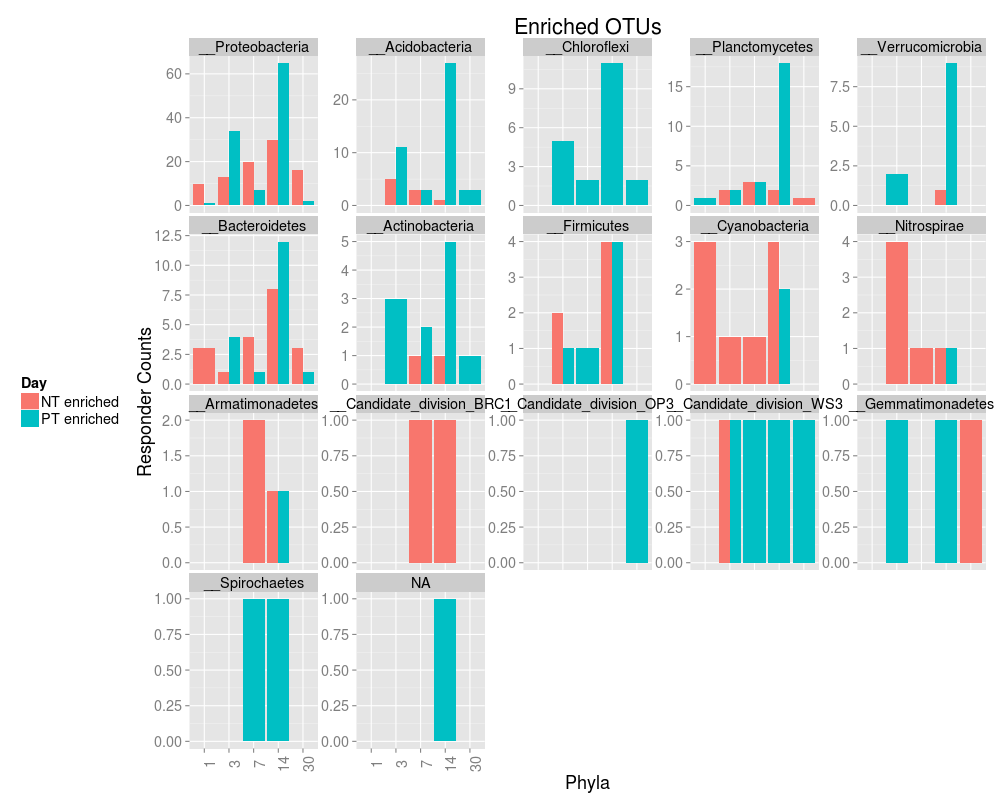

In [171]:
%%R -w 1000 -h 800
dcounts = new_df.l2fc %>%
          #filter(!is.na(log2FoldChange)) %>%
          #filter(!is.na(padj)) %>%
          filter(Resp_status %in% c("NT enriched", "PT enriched")) %>%
          group_by(Rank2, Day, Resp_status, Substrate) %>%
          summarize(responders = sum(padj<= 0.10))
#dcounts = filter(dcounts, Rank2 %in% c("__Proteobacteria", "__Acidobacteria", "__Bacteroidetes", "__Planctomycetes", "__Chloroflexi", "__Actinobacteria", "__Verrucomicrobia", "__Gemmatimonadetes", "__Candidate_division_WS3", "__Cyanobacteria", "__Armatimonadetes", "__Firmicutes", "__Nitrospirae", "__Chlorobi"))
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)
#newrow = c("__Firmicutes", "October", "PT enriched", as.numeric(0))
#dcounts = rbind(dcounts,newrow)
#newrow = c("__Armatimonadetes", "October", "PT enriched", 0)
#dcounts = rbind(dcounts,newrow)
#newrow = c("__Armatimonadetes", "November", "PT enriched", 0)
#dcounts = rbind(dcounts,newrow)
#newrow = c("__Cyanobacteria", "November", "PT enriched", 0)
#dcounts = rbind(dcounts,newrow)
dcounts$Rank2 <- droplevels(dcounts$Rank2)
#dcounts$responders= as.numeric(dcounts$responders)
#dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)

p = ggplot(dcounts, aes(x = as.factor(Day) , y = responders, fill = as.factor(Resp_status))) +
    geom_bar(stat = "identity", position="dodge") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap( ~ Rank2, ncol = 5, scales = "free_y") +
    #scale_y_discrete(limits = (0, 50)) +
    ggtitle("Enriched OTUs") + ylab("Responder Counts")+
    xlab("Phyla") + guides(fill=guide_legend(title="Day")) +
    theme(text = element_text(size=18), axis.text.x = element_text(angle=90, vjust=1), legend.position="left") 


p

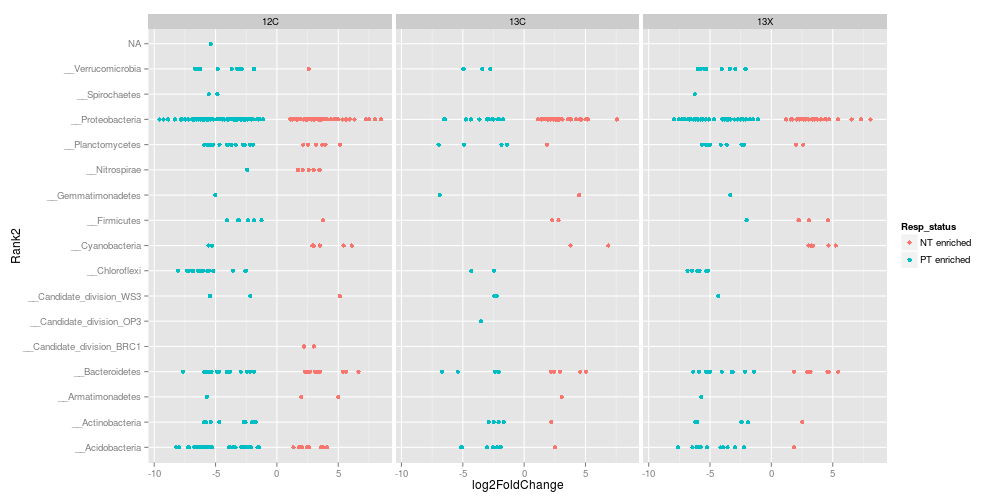

In [168]:
%%R -w 1000 -h 500
enriched = filter(new_df.l2fc, padj <=0.10)
head(enriched)

p = ggplot(enriched, aes(log2FoldChange, Rank2))
p = p + geom_point(aes(color = Resp_status))
p = p + facet_wrap(~Substrate, ncol = 5)
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
#p = p + scale_colour_discrete((name="Responder Status"),
 #                        labels =c("Nonresponder/Unknown", "DNA and RNA Responder"))
p